# ```Identifying Rhode Island characteristics and predicting whether a response came from a resident of Rhode Island or another New England state using 2017 BRFSS data```

In [1]:
# %load ../standard_imports.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Toolbox

def check_for_dtypes(df):
    print('Checking dtypes')
    print('-'*20)
    for col in df.columns:
        print('{:10} {}'.format(col,df[col].dtype))

def count_na(df):
    print('Checking % of NaN\'s')
    print('-'*25)
    total_row = df.shape[0]
    for col in df.columns:
        total_na_counts = df_newengland[col][df_newengland[col].isna()==True].shape[0]
        print('{:10} : {:5.2f}% NaN'.format(col,total_na_counts/total_row * 100 ))

def fill_na_with_mean(df,cols):
    for col in cols:
        df.loc[:,col] = df.loc[:,col].fillna(df[col].mean())

def convert_to_int32(df,cols):
    for col in cols:
        df.loc[:,col] = df.loc[:,col].astype(dtype='int32')

def count_unique_values(df):
    print('Count unique values')
    print('-'*25)
    for col in df.columns:
        count_uniques = df_newengland[col].unique().shape[0]
        print('{:10} : {}'.format(col, count_uniques))
        
def list_unique_values(df):
    print('List unique values')
    print('-'*25)
    for col in df.columns:
        list_uniques = sorted(df_newengland[col].unique())
        print('{:10} : {}'.format(col, list_uniques))

def create_new_column_NA(df,col,nums):
    df[col+'_NA'] = 0
    for num in nums:
        df.loc[df[col]==num,col+'_NA'] = 1

def replace_num_with_mean(df,col,nums):
    mean = df[df[col+'_NA']==0][col].mean() #excluding the num's when calculating mean
    for num in nums:
        df.loc[df[col]==num,col] = mean 

In [3]:
# Tools for evaluating model performance

from sklearn import metrics


def get_y_preds(model,X,sets):

    y_pred, y_pred_proba = {},{}

    for s in sets:

        try:
            y_pred_proba[s] = model.predict_proba(X[s])
        except:
            y_pred_proba[s] = model.predict(X[s]) #for NN and LGBM
            
    return y_pred, y_pred_proba

    
def get_fpt_tpr(y,y_pred_proba,sets):

    fpr, tpr, threshold, roc_auc = {},{},{},{}

    for s in sets:
    
        try:
            fpr[s], tpr[s], threshold[s] = metrics.roc_curve(y[s], y_pred_proba[s])
        except:
            fpr[s], tpr[s], threshold[s] = metrics.roc_curve(y[s], y_pred_proba[s][:,1]) #for kNN
            
        roc_auc[s] = metrics.auc(fpr[s], tpr[s])
        
    return fpr, tpr, threshold, roc_auc


def plot_ROC(fpr, tpr, threshold, roc_auc, model_str):

    plt.figure()
    lw = 2
    
    c = {'train':'darkorange','val':'black','test':'green'}
    
    for dataset in fpr.keys():
        plt.plot(fpr[dataset], tpr[dataset], color=c[dataset], lw=lw, label='{} {}: AUC = {:0.2f}'.format(model_str,dataset,roc_auc[dataset]))

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    
def evaluate_model(model,X,sets,model_str=''):

    _, y_pred_proba = get_y_preds(model,X,sets)

    fpr, tpr, threshold, roc_auc = get_fpt_tpr(y,y_pred_proba,sets)
    
    plot_ROC(fpr, tpr, threshold, roc_auc,model_str)    

    return fpr, tpr, threshold, roc_auc


def plot_ROC_compare_models(**kwargs):
    
    fprs = kwargs['fprs']
    tprs = kwargs['tprs']
    aucs = kwargs['aucs']
    
    lw = 1
    
    c = {'lr':'b','knn':'g','lgb':'r','nn':'c'}
    
    for model in fprs.keys():
        plt.plot(fprs[model]['test'], tprs[model]['test'], color=c[model], lw=lw, label='{} test: AUC {:0.2f}'.format(model,aucs[model]['test']))

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    

# Download, unzip, obtain subset of ```New England``` data

In [4]:
def download_unzip_rename_open_save():

    #download SAS file

    !wget -P test_dir https://www.cdc.gov/brfss/annual_data/2017/files/LLCP2017XPT.zip

    #Unzip and rename file

    !unzip -l test_dir/LLCP2017XPT.zip
    !unzip test_dir/LLCP2017XPT.zip -d test_dir
    !mv -v test_dir/LLCP2017.XPT\   test_dir/LLCP2017.XPT

    #Check file size

    !du -h BRFSS_data/LLCP2017.XPT

    #Open files (in chunks)

    iter_sas = pd.read_sas('BRFSS_data/LLCP2017.XPT', iterator=True, chunksize=10000)

    #Quickly check columns and their types

    for df in iter_sas: 
        check_for_dtypes(df)
        break

    # Only take at rows that contains New England states data                                                                                                                                             
    # New England/FIPS code: Maine/23, Vermont/50, New Hampshire/33, Massachusetts/25, Rhode Island/44, and Connecticut/9.                                                                                    

    df_newengland = pd.DataFrame()
    chunk_i = 1
    for chunk in iter_sas:
        if(chunk_i%5==0):print('chunk_i=',chunk_i*10000)
        df = chunk[(chunk['_STATE'] == 23) | 
              (chunk['_STATE'] == 50) |
              (chunk['_STATE'] == 33) |
              (chunk['_STATE'] == 25) |
              (chunk['_STATE'] == 44) |
              (chunk['_STATE'] == 9)
             ]
        df_newengland = pd.concat([df_newengland,df])
        chunk_i+=1

    #Check if correctly filtered

    print(df_newengland['_STATE'].unique())

    # Save df_newengland as file so no need to load raw files (for later)

    df_newengland.to_csv('BRFSS_data/LLCP2017_NewEngland.csv')

Only need to execute below once. Uncomment after downloading and saving subset correctly.

In [5]:
#download_unzip_rename_open_save()

# Load and preprocess subset of data (New England States)

In [6]:
# loading saved file

df_newengland = pd.read_csv('BRFSS_data/LLCP2017_NewEngland.csv',index_col=0)
df_newengland.shape

(45091, 358)

There are 358 features. Let's begin by manually selecting subset of features to analyze.

In [7]:
# Explore features: selected features (Name, Desciption, type, values)

selected_var = ['GENHLTH', #General Health, Ordinal, (best)1-5, 7:not sure, 9:refused
                'HLTHPLN1', #Have any health care coverage, Categorical, 1-2, 7:note sure, 9:refused
                'SEX', #Respondents Sex, Binary, 1-2, 9:refused
                'MARITAL', #Marital Status, Categorical, 1-6, 9:refused.
                'EDUCA', #Education Level, Ordinal, 1-6(more educated), 9:refused. 
                'EMPLOY1', #Employment Status, Categorical. 1-8, 9:refused.
                'INCOME2', #Income Level, Ordinal, 1-8(more income), 77:not sure, 99:refused
               ]

In [8]:
# Explore features: Calculated Variables.
# Select variables that provide distict information as much as possible.
# https://www.cdc.gov/brfss/annual_data/2017/pdf/2017-calculated-variables-version4-508.pdf

calc_var = ['_RFHLTH', #Section 1: Health Status. 
            '_PHYS14D', #Section 2: Healthy Days. physical health status
            '_MENT14D', #Section 2: Healthy Days. mental health status
            '_HCVU651', #Section 3: Health Care Access
            '_RFHYPE5', #Section 4: Hypertension Awareness 
            '_CHOLCH1', #Section 5: Cholesterol Awareness. cholesterol check within past five years.
#             '_RFCHOL1', #Section 5: Cholesterol Awareness. have been told by a doctor, nurse, or other health professional that it was high.
#             '_MICHD', #Section 6: Chronic Health Conditions. reported having coronary heart disease (CHD)
#             '_LTASTH1', #Section 6: Chronic Health Conditions. been told they have asthma.
#             '_CASTHM1', #Section 6: Chronic Health Conditions. been told they currently have asthma.
            '_ASTHMS1', #Section 6: Chronic Health Conditions. computed asthma status.
            '_DRDXAR1', #Section 6: Chronic Health Conditions. had a doctor diagnose them with some form of arthritis.
            '_LMTACT1', #Section 7: Arthritis Burden. limited usual activities.
#             '_LMTWRK1', #Section 7: Arthritis Burden. limited work activities.
#             '_LMTSCL1', #Section 7: Arthritis Burden. limited social activities.
#             'MRACORG1', #Section 8: Demographics. mrace1 with 77,88,99s removed. 
#             'MRACASC1', #Section 8: Demographics. MRACORG1 with 77,88,99s removed, in ascending order.
#             '_PRACE1', #Section 8: Demographics. preferred race category.
#             '_MRACE1', #Section 8: Demographics. calculated multiracial race categorization.
#             '_M_RACE', #Section 8: Demographics. multiracial race categorization.
#             '_HISPANC', #Section 8: Demographics. Hispanic, Latino(a), or of Spanish origin.
            '_RACE', #Section 8: Demographics. race/ethnicity categories.
#             '_RACEG21', #Section 8: Demographics. white non-Hispanic race group.
#             '_RACEGR3', #Section 8: Demographics. five-level race ethnicity category. 
#             '_RACE_G1', #Section 8: Demographics. race groups used for internet prevalence tables.
#             '_AGEG5YR', #Section 8: Demographics. fourteen-level age category.
#             '_AGE65YR', #Section 8: Demographics. two-level age category.
#             '_AGE80', #Section 8: Demographics. imputed age value collapsed above 80. 
            '_AGE_G', #Section 8: Demographics. six-level imputed age category. 
#             'HTIN4', #Section 8: Demographics. reported height in inches. 
#             'HTM4', #Section 8: Demographics. reported height in meters. 
#             'WTKG3', #Section 8: Demographics. reported weight in kilograms. 
#             '_BMI5', #Section 8: Demographics. body mass index (BMI)
            '_BMI5CAT', #Section 8: Demographics. four-categories of body mass index (BMI)
#             '_RFBMI5', #Section 8: Demographics. adults who have a body mass index greater than 25.00 (overweight or obese).
            '_CHLDCNT', #Section 8: Demographics. number of children in household.
            '_EDUCAG', #Section 8: Demographics. level of education completed.  
            '_INCOMG', #Section 8: Demographics. for income categories.
            '_SMOKER3', #Section 9: Tobacco Use. four-level smoker status
#             '_RFSMOK3', #Section 9: Tobacco Use. adults who are current smokers.
            '_ECIGSTS', #Section 10: E-Cigarettes. four-level e-cigarette smoker status
#             '_CURECIG', #Section 10: E-Cigarettes.  adults who are current e-cigarette users.
#             'DRNKANY5', #Section 11: Alcohol Consumption. adults who reported having had at least one drink of alcohol in the past 30 days. 
#             'DROCDY3_', #Section 11: Alcohol Consumption. drink-occasions-per-day. 
            '_RFBING5', #Section 11: Alcohol Consumption. binge drinkers (males having five or more drinks on one occasion, females having four or more drinks on one occasion).
#             '_DRNKWEK', #Section 11: Alcohol Consumption. calculated total number of alcoholic beverages consumed per week.
            '_RFDRHV5', #Section 11: Alcohol Consumption. heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week).
#             'FTJUDA2_', #Section 12: Fruits & Vegetables. fruit juice intake in times per day.
#             'FRUTDA2_', #Section 12: Fruits & Vegetables. fruit intake in times per day.
#             'GRENDA1_', #Section 12: Fruits & Vegetables. dark green vegetable intake in times per day.
#             'FRNCHDA_', #Section 12: Fruits & Vegetables. French-fry intake in times per day.
#             'POTADA1_', #Section 12: Fruits & Vegetables. potato servings per day.
#             'VEGEDA2_', #Section 12: Fruits & Vegetables. other vegetable intake in times per day.
#             '_MISFRT1', #Section 12: Fruits & Vegetables. the number of missing fruit responses. 
#             '_MISVEG1', #Section 12: Fruits & Vegetables. the number of missing vegetable responses.
#             '_FRTRES1', #Section 12: Fruits & Vegetables. missing any fruit responses.
#             '_VEGRES1', #Section 12: Fruits & Vegetables. missing any vegetable responses.
#             '_FRUTSU1', #Section 12: Fruits & Vegetables. total fruits consumed per day.
#             '_VEGESU1', #Section 12: Fruits & Vegetables. total vegetables consumed per day.
            '_FRTLT1A', #Section 12: Fruits & Vegetables. consume fruit 1 or more times per day.
            '_VEGLT1A', #Section 12: Fruits & Vegetables. consume vegetables 1 or more times per day.
#             '_FRT16A', #Section 12: Fruits & Vegetables. reported consuming fruit >16 per day.
#             '_VEG23A', #Section 12: Fruits & Vegetables. reported consuming vegetables >23 per day.
#             '_FRUITE1', #Section 12: Fruits & Vegetables. fruit exclusion from analyses.
#             '_VEGETE1', #Section 12: Fruits & Vegetables. for vegetable exclusion from analyses.
#             '_TOTINDA', #Section 13: Exercise (Physical Activity). adults who reported doing physical activity or exercise during the past 30 days other than their regular job. 
#             'METVL11_', #Section 13: Exercise (Physical Activity). activity met value for first activity.
#             'METVL21_', #Section 13: Exercise (Physical Activity). activity met value for second activity.
#             'MAXVO2_', #Section 13: Exercise (Physical Activity). estimated age-gender specific maximum oxygen consumption.
#             'FC60_', #Section 13: Exercise (Physical Activity). estimated functional capacity.
#             'ACTIN11_', #Section 13: Exercise (Physical Activity). estimated activity intensity for first activity.
#             'ACTIN21_', #Section 13: Exercise (Physical Activity). estimated activity intensity for second activity.
#             'PADUR1_', #Section 13: Exercise (Physical Activity). minutes of first activity.
#             'PADUR2_', #Section 13: Exercise (Physical Activity). minutes of second activity.
#             'PAFREQ1_', #Section 13: Exercise (Physical Activity). physical activity frequency per week for first activity.
#             'PAFREQ2_', #Section 13: Exercise (Physical Activity). physical activity frequency per week for second activity. 
#             '_MINAC11', #Section 13: Exercise (Physical Activity). minutes of physical activity per week for first activity.
#             '_MINAC21', #Section 13: Exercise (Physical Activity). minutes of physical activity per week for second activity.
#             'STRFREQ_', #Section 13: Exercise (Physical Activity). strength activity frequency per week. 
#             'PAMISS1_', #Section 13: Exercise (Physical Activity). missing physical activity data. 
#             'PAMIN11_', #Section 13: Exercise (Physical Activity). minutes of physical activity per week for first activity.
#             'PAMIN21_', #Section 13: Exercise (Physical Activity). minutes of physical activity per week for second activity.
#             'PA1MIN_', #Section 13: Exercise (Physical Activity). minutes of total physical activity per week.
#             'PAVIG11_', #Section 13: Exercise (Physical Activity). minutes of vigorous physical activity per week for first activity.
#             'PAVIG21_', #Section 13: Exercise (Physical Activity). minutes of vigorous physical activity per week for second activity.
#             'PA1VIGM_', #Section 13: Exercise (Physical Activity). minutes of total vigorous physical activity per week.
            '_PACAT1', #Section 13: Exercise (Physical Activity). physical activity categories.
#             '_PAINDX1', #Section 13: Exercise (Physical Activity). physical activity index. 
#             '_PA150R2', #Section 13: Exercise (Physical Activity). adults that participated in 150 minutes (or vigorous equivalent minutes) of physical activity per week.
#             '_PA300R2', #Section 13: Exercise (Physical Activity). adults that participated in 300 minutes (or vigorous equivalent minutes) of physical activity per week.
#             '_PA30021', #Section 13: Exercise (Physical Activity). adults that participated in 300 minutes (or vigorous equivalent minutes) of physical activity per week (2-levels)
#             '_PASTRNG', #Section 13: Exercise (Physical Activity). muscle strengthening recommendation.
#             '_PAREC1', #Section 13: Exercise (Physical Activity). aerobic and strengthening guideline.
#             '_PASTAE1', #Section 13: Exercise (Physical Activity). aerobic and strengthening (2-level).
            '_RFSEAT2', #Section 14: Seatbelt Use. always or nearly always wear seat belts
#             '_RFSEAT3', #Section 14: Seatbelt Use. always wear seat belts.
#             '_FLSHOT6', #Section 15: Immunization. adults aged 65+ who have had a flu shot within the past year.
#             '_PNEUMO2', #Section 15: Immunization. adults aged 65+ who have ever had a pneumonia vaccination. 
            '_AIDTST3', #Section 16: HIV/AIDS. adults who have ever been tested for HIV.
           ]
            

In [9]:
# Combined all selected variables

all_selected_var = selected_var + calc_var

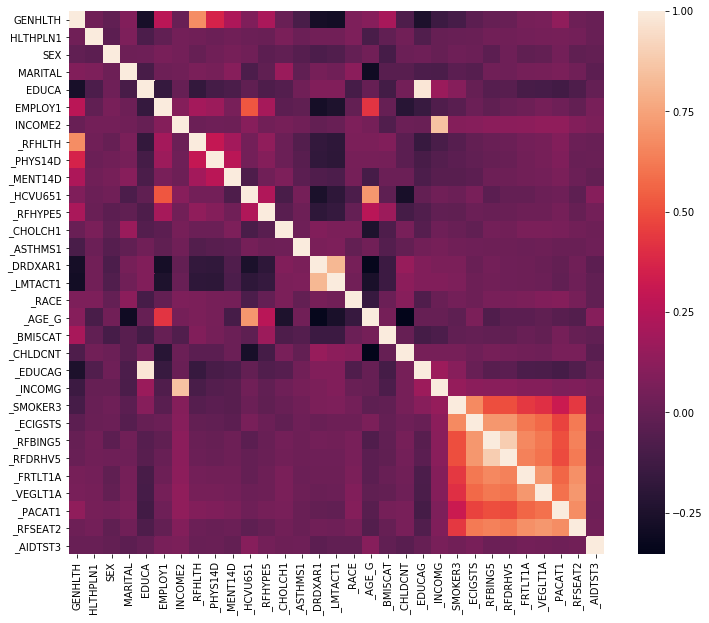

In [11]:
# Check for correlation to have a general sense of the variables

fig, ax = plt.subplots(figsize=(12,10))
ax = sns.heatmap(df_newengland[all_selected_var].corr(), xticklabels=all_selected_var, yticklabels=all_selected_var)

Note: Categorical variables are not expected to show any meaningful correlations.

Remove high correlations to satisfy the assumptions of feature independence for certain models.

In [12]:
# Experimenting: select and remove non-categorical features that are introducing high correlations

remove_var_list = [
    'EDUCA',
    'INCOME2',
    '_AGE_G',
    '_RFHLTH',
    '_ECIGSTS',
    '_RFBING5',
    '_FRTLT1A',
    '_LMTACT1',
    '_RFSEAT2',
]

def remove_var_from(list_a,list_b):
    for var in list_b:
        if(var in list_a):list_a.remove(var)
        
remove_var_from(all_selected_var,remove_var_list)

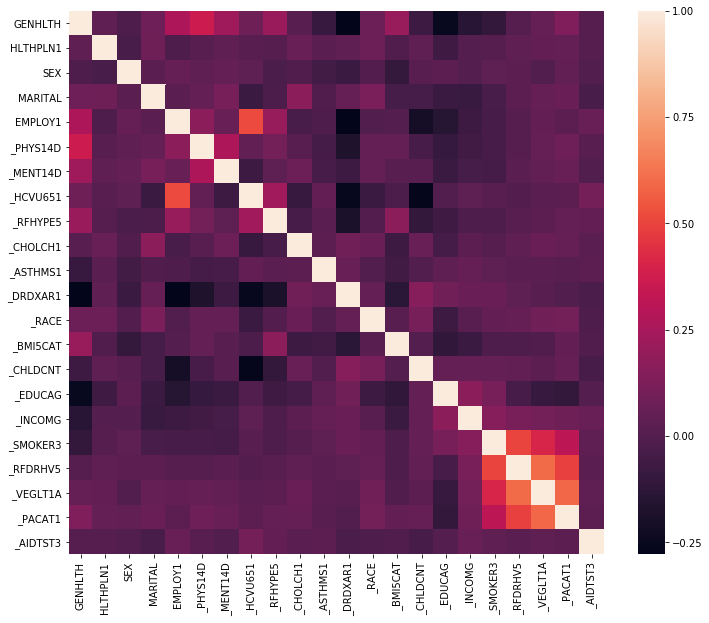

In [13]:
# Check again for correlations

fig, ax = plt.subplots(figsize=(12,10))
ax = sns.heatmap(df_newengland[all_selected_var].corr(), xticklabels=all_selected_var, yticklabels=all_selected_var)


In [14]:
# Clean data and check for NaNs's

count_na(df_newengland[all_selected_var])

Checking % of NaN's
-------------------------
GENHLTH    :  0.00% NaN
HLTHPLN1   :  0.00% NaN
SEX        :  0.00% NaN
MARITAL    :  0.00% NaN
EMPLOY1    :  0.00% NaN
_PHYS14D   :  0.00% NaN
_MENT14D   :  0.00% NaN
_HCVU651   :  0.00% NaN
_RFHYPE5   :  0.00% NaN
_CHOLCH1   :  0.00% NaN
_ASTHMS1   :  0.00% NaN
_DRDXAR1   :  0.59% NaN
_RACE      :  0.00% NaN
_BMI5CAT   :  8.22% NaN
_CHLDCNT   :  0.00% NaN
_EDUCAG    :  0.00% NaN
_INCOMG    :  0.00% NaN
_SMOKER3   :  0.00% NaN
_RFDRHV5   :  0.00% NaN
_VEGLT1A   :  0.00% NaN
_PACAT1    :  0.00% NaN
_AIDTST3   :  9.41% NaN


In [15]:
# List the unique values in our selected features

list_unique_values(df_newengland[all_selected_var])

List unique values
-------------------------
GENHLTH    : [1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 9.0]
HLTHPLN1   : [1.0, 2.0, 7.0, 9.0]
SEX        : [1.0, 2.0, 9.0]
MARITAL    : [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0]
EMPLOY1    : [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
_PHYS14D   : [1.0, 2.0, 3.0, 9.0]
_MENT14D   : [1.0, 2.0, 3.0, 9.0]
_HCVU651   : [1.0, 2.0, 9.0]
_RFHYPE5   : [1.0, 2.0, 9.0]
_CHOLCH1   : [1.0, 2.0, 3.0, 9.0]
_ASTHMS1   : [1.0, 2.0, 3.0, 9.0]
_DRDXAR1   : [1.0, 2.0, nan]
_RACE      : [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
_BMI5CAT   : [3.0, nan, 1.0, 2.0, 4.0]
_CHLDCNT   : [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0]
_EDUCAG    : [1.0, 2.0, 3.0, 4.0, 9.0]
_INCOMG    : [1.0, 2.0, 3.0, 4.0, 5.0, 9.0]
_SMOKER3   : [1.0, 2.0, 3.0, 4.0, 9.0]
_RFDRHV5   : [1.0, 2.0, 9.0]
_VEGLT1A   : [1.0, 2.0, 9.0]
_PACAT1    : [1.0, 2.0, 3.0, 4.0, 9.0]
_AIDTST3   : [1.0, 2.0, nan, 9.0]


In [16]:
# Replacing NaN's
# Need to be more careful how to fill the NaN's
# There are NaN's as 9 or 99, based on codebook. 

for col in ['_DRDXAR1','_BMI5CAT','_AIDTST3']: df_newengland[col].fillna(9, inplace=True)

In [17]:
# Check if NaN correctly replaced

count_na(df_newengland[all_selected_var])

Checking % of NaN's
-------------------------
GENHLTH    :  0.00% NaN
HLTHPLN1   :  0.00% NaN
SEX        :  0.00% NaN
MARITAL    :  0.00% NaN
EMPLOY1    :  0.00% NaN
_PHYS14D   :  0.00% NaN
_MENT14D   :  0.00% NaN
_HCVU651   :  0.00% NaN
_RFHYPE5   :  0.00% NaN
_CHOLCH1   :  0.00% NaN
_ASTHMS1   :  0.00% NaN
_DRDXAR1   :  0.00% NaN
_RACE      :  0.00% NaN
_BMI5CAT   :  0.00% NaN
_CHLDCNT   :  0.00% NaN
_EDUCAG    :  0.00% NaN
_INCOMG    :  0.00% NaN
_SMOKER3   :  0.00% NaN
_RFDRHV5   :  0.00% NaN
_VEGLT1A   :  0.00% NaN
_PACAT1    :  0.00% NaN
_AIDTST3   :  0.00% NaN


In [18]:
# Summarizing data types based on MANUALLY STUDYING the variables based on the codebook, 

# 'GENHLTH',  # -- Ordinal 
# 'HLTHPLN1', # -- Categorical
# 'SEX',      # -- Categorical
# 'MARITAL',  # -- Categorical
# 'EDUCA',    # -- Ordinal 
# 'EMPLOY1',  # -- Categorical
# 'INCOME2',  # -- Ordinal                
# '_RFHLTH',  # -- Categorical
# '_PHYS14D', # -- Ordinal 
# '_MENT14D', # -- Ordinal
# '_HCVU651', # -- Categorical
# '_RFHYPE5', # -- Categorical 
# '_CHOLCH1', # -- Categorical
# '_ASTHMS1', # -- Categorical
# '_DRDXAR1', # -- Categorical
# '_LMTACT1', # -- Categorical
# '_RACE',    # -- Categorical
# '_AGE_G',   # -- Ordinal
# '_BMI5CAT', # -- Ordinal
# '_CHLDCNT', # -- Ordinal
# '_EDUCAG',  # -- Ordinal 
# '_INCOMG',  # -- Ordinal
# '_SMOKER3', # -- Ordinal
# '_ECIGSTS', # -- Ordinal
# '_RFBING5', # -- Categorical
# '_RFDRHV5', # -- Categorical
# '_FRTLT1A', # -- Categorical
# '_VEGLT1A', # -- Categorical
# '_PACAT1',  # -- Ordinal
# '_RFSEAT2', # -- Categorical
# '_AIDTST3', # -- Categorical


In [19]:
# Collect the ordinal features 

ordinal_var = [
'GENHLTH', # -- Ordinal 
'EDUCA',   # -- Ordinal 
'INCOME2', # -- Ordinal                
'_PHYS14D', # -- Ordinal 
'_MENT14D', # -- Ordinal
# '_AGE_G', # -- Ordinal --> does not have a missing value for some reason. so exclude
'_BMI5CAT', # -- Ordinal
'_CHLDCNT', # -- Ordinal
'_EDUCAG', # -- Ordinal 
'_INCOMG', # -- Ordinal
'_SMOKER3', # -- Ordinal
'_ECIGSTS', # -- Ordinal
'_PACAT1', # -- Ordinal
]

# Exclude features that were removed
remove_var_from(ordinal_var,remove_var_list)

In [20]:
list_unique_values(df_newengland[ordinal_var])

List unique values
-------------------------
GENHLTH    : [1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 9.0]
_PHYS14D   : [1.0, 2.0, 3.0, 9.0]
_MENT14D   : [1.0, 2.0, 3.0, 9.0]
_BMI5CAT   : [1.0, 2.0, 3.0, 4.0, 9.0]
_CHLDCNT   : [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0]
_EDUCAG    : [1.0, 2.0, 3.0, 4.0, 9.0]
_INCOMG    : [1.0, 2.0, 3.0, 4.0, 5.0, 9.0]
_SMOKER3   : [1.0, 2.0, 3.0, 4.0, 9.0]
_PACAT1    : [1.0, 2.0, 3.0, 4.0, 9.0]


In [21]:
# Attempt to make ordinal variables represented as a consistent continuous variable. 
# Remove 7/9/77/99 as separate column
# The idea here is that we create an extra column for each of the ordinal variables to indicate a binary response of "don't know/not sure/refused".
# Then replace the 7/9/77/99 with mean

ordinal_var_NA = [col+'_NA' for col in ordinal_var]
for col in ordinal_var:
    nums = [9]
    if col=='GENHLTH': nums = [7,9]
    if col=='INCOME2': nums = [77,99]

    create_new_column_NA(df_newengland,col,nums)
    replace_num_with_mean(df_newengland,col,nums)
    

In [22]:
# Check if ordinal prepropressing is implemented correctly

list_unique_values(df_newengland[ordinal_var])
list_unique_values(df_newengland[ordinal_var_NA])

List unique values
-------------------------
GENHLTH    : [1.0, 2.0, 2.4510588183010023, 3.0, 4.0, 5.0]
_PHYS14D   : [1.0, 1.503139681966028, 2.0, 3.0]
_MENT14D   : [1.0, 1.4347209720972096, 2.0, 3.0]
_BMI5CAT   : [1.0, 2.0, 2.9091919582447323, 3.0, 4.0]
_CHLDCNT   : [1.0, 1.4019481098430813, 2.0, 3.0, 4.0, 5.0, 6.0]
_EDUCAG    : [1.0, 2.0, 3.0, 3.108239959011829, 4.0]
_INCOMG    : [1.0, 2.0, 3.0, 3.9443055667553693, 4.0, 5.0]
_SMOKER3   : [1.0, 2.0, 3.0, 3.325265205910965, 4.0]
_PACAT1    : [1.0, 2.0, 2.330712222082653, 3.0, 4.0]
List unique values
-------------------------
GENHLTH_NA : [0, 1]
_PHYS14D_NA : [0, 1]
_MENT14D_NA : [0, 1]
_BMI5CAT_NA : [0, 1]
_CHLDCNT_NA : [0, 1]
_EDUCAG_NA : [0, 1]
_INCOMG_NA : [0, 1]
_SMOKER3_NA : [0, 1]
_PACAT1_NA : [0, 1]


In [23]:
# Collect the categorical features
# Make categorical variables become integers types
# Make one-hot-encoding for these features.

categorical_var =[
'HLTHPLN1', # -- Categorical
'SEX',      # -- Categorical
'MARITAL',  # -- Categorical
'EMPLOY1',  # -- Categorical
'_RFHLTH',  # -- Categorical
'_HCVU651', # -- Categorical
'_RFHYPE5', # -- Categorical 
'_CHOLCH1', # -- Categorical
'_ASTHMS1', # -- Categorical
'_DRDXAR1', # -- Categorical
'_LMTACT1', # -- Categorical
'_RACE',    # -- Categorical
'_RFBING5', # -- Categorical
'_RFDRHV5', # -- Categorical
'_FRTLT1A', # -- Categorical
'_VEGLT1A', # -- Categorical
'_RFSEAT2', # -- Categorical
'_AIDTST3', # -- Categorical
]

# Exclude features that were removed
remove_var_from(categorical_var,remove_var_list)

#Convert the categorical data to int
convert_to_int32(df_newengland,categorical_var)

# Make one-hot-encoding for categorical variables
for col in categorical_var:
    temp =  pd.get_dummies(df_newengland[col],prefix=col)
    df_newengland = df_newengland.merge(temp, left_index=True, right_index=True)

In [24]:
#Create dictionary for the one hot encodings categorical variables

one_hot = {}
one_hot_catergorical_var_all = []
for col in categorical_var:
    one_hot[col] = [col+'_'+str(val) for val in sorted(df_newengland[col].unique())]
    one_hot_catergorical_var_all+=one_hot[col]


In [25]:
# Check if one hot implemented correctly

df_newengland[one_hot['_RACE']].head()

,_RACE_1,_RACE_2,_RACE_3,_RACE_4,_RACE_5,_RACE_6,_RACE_7,_RACE_8,_RACE_9
49938,1,0,0,0,0,0,0,0,0
49939,1,0,0,0,0,0,0,0,0
49940,0,0,0,1,0,0,0,0,0
49941,1,0,0,0,0,0,0,0,0
49942,1,0,0,0,0,0,0,0,0


In [26]:
# Put together all variables for model fitting

final_vars = ordinal_var+ordinal_var_NA+one_hot_catergorical_var_all
final_vars

['GENHLTH',
 '_PHYS14D',
 '_MENT14D',
 '_BMI5CAT',
 '_CHLDCNT',
 '_EDUCAG',
 '_INCOMG',
 '_SMOKER3',
 '_PACAT1',
 'GENHLTH_NA',
 '_PHYS14D_NA',
 '_MENT14D_NA',
 '_BMI5CAT_NA',
 '_CHLDCNT_NA',
 '_EDUCAG_NA',
 '_INCOMG_NA',
 '_SMOKER3_NA',
 '_PACAT1_NA',
 'HLTHPLN1_1',
 'HLTHPLN1_2',
 'HLTHPLN1_7',
 'HLTHPLN1_9',
 'SEX_1',
 'SEX_2',
 'SEX_9',
 'MARITAL_1',
 'MARITAL_2',
 'MARITAL_3',
 'MARITAL_4',
 'MARITAL_5',
 'MARITAL_6',
 'MARITAL_9',
 'EMPLOY1_1',
 'EMPLOY1_2',
 'EMPLOY1_3',
 'EMPLOY1_4',
 'EMPLOY1_5',
 'EMPLOY1_6',
 'EMPLOY1_7',
 'EMPLOY1_8',
 'EMPLOY1_9',
 '_HCVU651_1',
 '_HCVU651_2',
 '_HCVU651_9',
 '_RFHYPE5_1',
 '_RFHYPE5_2',
 '_RFHYPE5_9',
 '_CHOLCH1_1',
 '_CHOLCH1_2',
 '_CHOLCH1_3',
 '_CHOLCH1_9',
 '_ASTHMS1_1',
 '_ASTHMS1_2',
 '_ASTHMS1_3',
 '_ASTHMS1_9',
 '_DRDXAR1_1',
 '_DRDXAR1_2',
 '_DRDXAR1_9',
 '_RACE_1',
 '_RACE_2',
 '_RACE_3',
 '_RACE_4',
 '_RACE_5',
 '_RACE_6',
 '_RACE_7',
 '_RACE_8',
 '_RACE_9',
 '_RFDRHV5_1',
 '_RFDRHV5_2',
 '_RFDRHV5_9',
 '_VEGLT1A_1',
 '_VEGLT1A

# Identifying features that distinguish Rhode Island from at least three other New England states

The strategy we adopt is by fitting a model, where the data is labelled 1 if is RI, and 0 if it is non-RI state. Then to identity distinguishing features of Rhode Island, we look at and interpreting the feature importance from the fit given the data.

In [27]:
# Choose three other New England state and consider the total responses from each states:

state_dict = {'Maine':23,'Vermont':50,'New Hampshire':33,'Massachusetts':25,'Rhode Island':44,'Connecticut':9}

def how_many_responses(df,state):
    print ('{:15} : {:5d} responses'.format(state,df[df['_STATE']==state_dict[state]].shape[0]))
    
how_many_responses(df_newengland,'Maine')
how_many_responses(df_newengland,'Vermont')
how_many_responses(df_newengland,'New Hampshire')
how_many_responses(df_newengland,'Massachusetts')
how_many_responses(df_newengland,'Rhode Island')
how_many_responses(df_newengland,'Connecticut')

Maine           :  9692 responses
Vermont         :  6516 responses
New Hampshire   :  5751 responses
Massachusetts   :  6912 responses
Rhode Island    :  5632 responses
Connecticut     : 10588 responses


We will choose three non-RI states, and create label 1 for Rhode Island, 0 for non-RI states. 

And to make the dataset balanced we will sample the non-RI states in equal proportions and such that the total non-RI dataset is in equal number of rows as the RI dataset.

We choose Vermont, New Hampshire and Massachusetts all together as non-Rhode Island states to compare with Rhode Island.

In [28]:
# TODO if there is time: Experiment with different ways of sampling

In [29]:
# Make dataset balanced,

RI_sample_count = 5632
n_downSample = RI_sample_count/3

In [30]:
# Choose: Vermont, New Hampshire, Massachusets (This choise is arbitrary)
# Make labels: 
# Y={State; 0:Non-RhodeIsland, 1:RhodeIsland} 
# X={selected responses}

from sklearn.model_selection import train_test_split, cross_val_score, KFold

X,y = {},{}

In [31]:
#Vermont
X['VT'] = df_newengland[df_newengland['_STATE']==50][final_vars].sample(n=int(RI_sample_count/3))
y['VT'] = np.zeros(X['VT'].shape[0])

#New Hampshire
X['NH'] = df_newengland[df_newengland['_STATE']==33][final_vars].sample(n=int(RI_sample_count/3))
y['NH'] = np.zeros(X['NH'].shape[0])

#Massachusets
X['MA'] = df_newengland[df_newengland['_STATE']==25][final_vars].sample(n=int(RI_sample_count/3))
y['MA'] = np.zeros(X['MA'].shape[0])

#Rhode island
X['RI'] = df_newengland[df_newengland['_STATE']==44][final_vars].sample(n=5632)
y['RI'] = np.ones(X['RI'].shape[0])

#Concatenate all 4 states.
X['All'] = pd.concat([X['VT'],X['NH'],X['MA'],X['RI']])
y['All'] = np.concatenate([y['VT'],y['NH'],y['MA'],y['RI']])

In [32]:
# Cross validation spliting 
# Split dataset 70:30 , train:test

# split  All --> train | test 
X['train'], X['test'], y['train'], y['test'] = train_test_split(X['All'], y['All'], test_size=0.3, random_state=3)

In [33]:
# Check resulting total rows

X['train'].shape

(7884, 76)

In [34]:
# Experiment: not using one hot encoding, need to create separate training set.

final_vars_no1h = ordinal_var+ordinal_var_NA+categorical_var

X_no1h = {}

#Vermont
X_no1h['VT'] = df_newengland[df_newengland['_STATE']==50][final_vars_no1h].sample(n=int(RI_sample_count/3))

#New Hampshire
X_no1h['NH'] = df_newengland[df_newengland['_STATE']==33][final_vars_no1h].sample(n=int(RI_sample_count/3))

#Massachusets
X_no1h['MA'] = df_newengland[df_newengland['_STATE']==25][final_vars_no1h].sample(n=int(RI_sample_count/3))

#Rhode island
X_no1h['RI'] = df_newengland[df_newengland['_STATE']==44][final_vars_no1h].sample(n=5632)

#Concatenate all 4 states.
X_no1h['All'] = pd.concat([X_no1h['VT'],X_no1h['NH'],X_no1h['MA'],X_no1h['RI']])

In [35]:
# Cross validation spliting - X_no1h
# Split dataset 70:30 

# split  All --> train | test 
X_no1h['train'], X_no1h['test'], y['train'], y['test'] = train_test_split(X_no1h['All'], y['All'], test_size=0.3, random_state=3)

In [36]:
# Check resulting columns 

X_no1h['train'].columns

Index(['GENHLTH', '_PHYS14D', '_MENT14D', '_BMI5CAT', '_CHLDCNT', '_EDUCAG',
       '_INCOMG', '_SMOKER3', '_PACAT1', 'GENHLTH_NA', '_PHYS14D_NA',
       '_MENT14D_NA', '_BMI5CAT_NA', '_CHLDCNT_NA', '_EDUCAG_NA', '_INCOMG_NA',
       '_SMOKER3_NA', '_PACAT1_NA', 'HLTHPLN1', 'SEX', 'MARITAL', 'EMPLOY1',
       '_HCVU651', '_RFHYPE5', '_CHOLCH1', '_ASTHMS1', '_DRDXAR1', '_RACE',
       '_RFDRHV5', '_VEGLT1A', '_AIDTST3'],
      dtype='object')

### Scale features

In [37]:
# Scale inputs, for models that may benefit from it. eg kNN, NN.

from sklearn.preprocessing import StandardScaler
X_scaled = {}

scaler = StandardScaler().fit(X['train'])
X_scaled['train'] = scaler.transform(X['train'])
scaler = StandardScaler().fit(X['test'])
X_scaled['test'] = scaler.transform(X['test'])

/anaconda2/envs/BCBI_BRFSS_classifier/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda2/envs/BCBI_BRFSS_classifier/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  import sys
/anaconda2/envs/BCBI_BRFSS_classifier/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda2/envs/BCBI_BRFSS_classifier/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


## Model fitting : Logistic regression

In [38]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear',penalty='l1',C=0.1)
lr.fit(X['train'],y['train'])

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

We evaluate fit using ROC curve, ie. true positive rate versus false positive rate

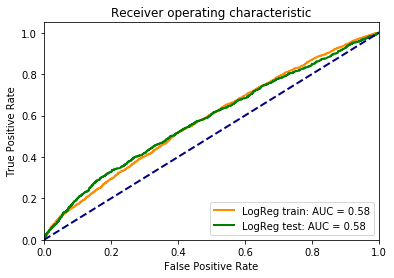

In [39]:
fpr_lr,tpr_lr,_,auc_lr = evaluate_model(lr,X,['train','test'],'LogReg')

In [40]:
lr_result = pd.DataFrame(np.transpose(lr.coef_),columns=['Coefficients'],index=final_vars)
lr_result['odds'] = np.exp(lr_result['Coefficients'])

In [41]:
# Showing parameters whose odds are greater than 1.1

lr_result[np.abs(lr_result['odds'])>1.1].sort_values(by=['odds'],ascending=False)

,Coefficients,odds
_RACE_8,0.606230,1.833507
_CHOLCH1_1,0.248155,1.281659
EMPLOY1_3,0.225174,1.252541
_RACE_2,0.191504,1.211070
MARITAL_5,0.114917,1.121781


In [42]:
# Showing parameters whose odds are less than 0.9

lr_result[np.abs(lr_result['odds'])<0.9].sort_values(by=['odds'],ascending=True)

,Coefficients,odds
_CHOLCH1_2,-0.249219,0.779409
_PHYS14D_NA,-0.187931,0.828672
_RACE_1,-0.181395,0.834106
EMPLOY1_2,-0.115271,0.891125


The odds show what features are likely to be associated with Rhode Island.

# Evaluating at least three other classifiers to predict what state associated is associated with a set of responses

### k Nearest Neighbours

In [43]:
from sklearn.neighbors import KNeighborsClassifier

auc_train={}
auc_test={}
knn={}

In [44]:
for k in range(10,71,20):

    knn[k] = KNeighborsClassifier(n_neighbors=k,p=1)
    knn[k].fit(X_scaled['train'], y['train']) 

    y_pred_proba_train = knn[k].predict_proba(X_scaled['train'])
    auc_train[k] = metrics.roc_auc_score(y['train'], y_pred_proba_train[:,1])

    y_pred_proba_test = knn[k].predict_proba(X_scaled['test'])
    auc_test[k] = metrics.roc_auc_score(y['test'], y_pred_proba_test[:,1])

    print ("k = {:3d} auc train = {:.2f} auc test = {:.2f}".format(k,auc_train[k],auc_test[k]))

k =  10 auc train = 0.70 auc test = 0.53
k =  30 auc train = 0.64 auc test = 0.56
k =  50 auc train = 0.62 auc test = 0.57
k =  70 auc train = 0.61 auc test = 0.56


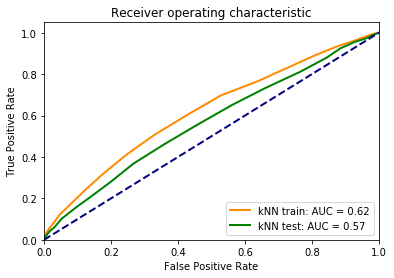

In [49]:
knn_optimal = knn[50]
fpr_knn,tpr_knn,_,auc_knn = evaluate_model(knn_optimal,X_scaled,['train','test'],'kNN')

## LightGBM - Boosting Decision Tree 

/anaconda2/envs/BCBI_BRFSS_classifier/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


Training until validation scores don't improve for 10 rounds.
[250]	train's binary_logloss: 0.691363	test's binary_logloss: 0.691572
[500]	train's binary_logloss: 0.690126	test's binary_logloss: 0.690536
[750]	train's binary_logloss: 0.689295	test's binary_logloss: 0.689818
[1000]	train's binary_logloss: 0.688645	test's binary_logloss: 0.689194
[1250]	train's binary_logloss: 0.688092	test's binary_logloss: 0.688659
[1500]	train's binary_logloss: 0.68762	test's binary_logloss: 0.688201
[1750]	train's binary_logloss: 0.687209	test's binary_logloss: 0.687805
[2000]	train's binary_logloss: 0.686833	test's binary_logloss: 0.687418
[2250]	train's binary_logloss: 0.686502	test's binary_logloss: 0.68708
[2500]	train's binary_logloss: 0.686193	test's binary_logloss: 0.686794
[2750]	train's binary_logloss: 0.685914	test's binary_logloss: 0.68651
[3000]	train's binary_logloss: 0.685646	test's binary_logloss: 0.686227
[3250]	train's binary_logloss: 0.685394	test's binary_logloss: 0.68596
[3500]	tr

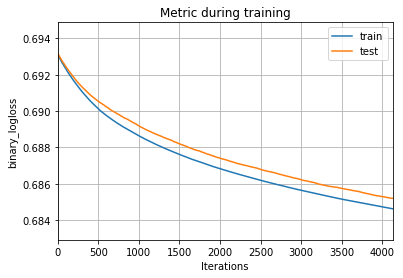

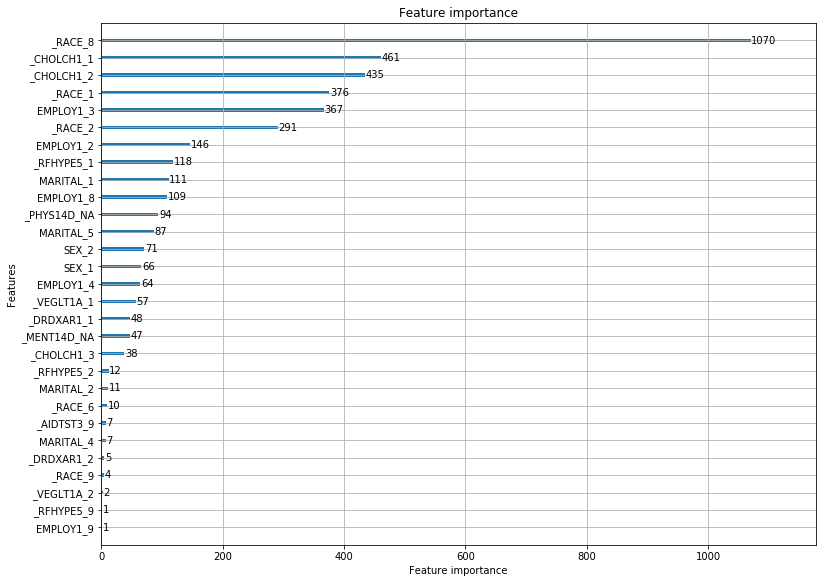

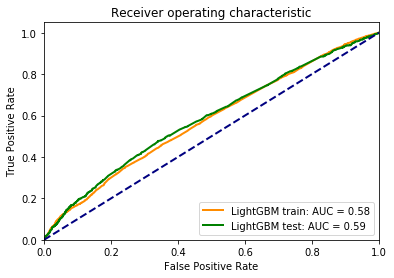

In [46]:
import lightgbm as lgb

evals_result={}
lgb_data = {}

# Experimenting: feed the original categorical non-oneHotVecvtor form.
# lgb_data['train'] = lgb.Dataset(X_no1h['train'], label=y['train'])
# lgb_data['val'] = lgb.Dataset(X_no1h['test'], label=y['test'])

lgb_data['train'] = lgb.Dataset(X['train'], label=y['train'])
lgb_data['test'] = lgb.Dataset(X['test'], label=y['test'])


lgb_params = {
    'boosting_type': 'gbdt',
    'task':'train',
    'verbose':0,
    'metric': 'binary_logloss',
    'objective': 'binary',
    'feature_fraction': .8,
    'bagging_freq':5,
    'bagging_fraction': 0.75,#0.75 
    'bagging_seed': 2**7, 
    'num_leaves': 2,
    'max_bin': 2,
    'learning_rate': 0.001, 
    'lambda_l1':0.1
}

num_boost_round = 5000
verbose_eval = int(num_boost_round/20)
lgb_model = lgb.train(lgb_params, 
                  lgb_data['train'],
                  valid_sets=[lgb_data['train'], lgb_data['test']],
                  valid_names=['train','test'],
                  num_boost_round=num_boost_round,
                  evals_result=evals_result,
                  early_stopping_rounds=10,
                  verbose_eval=verbose_eval)

# print ('evals_result = '),evals_result
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='binary_logloss')
# if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_metric_"+saveName+".pdf")

print('Plot feature importances...')
ax = lgb.plot_importance(lgb_model, max_num_features=X['test'].shape[1])
ax.figure.set_size_inches(6.4*2,4.8*2)
# if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_importance_"+saveName+".pdf")

# ROC
fpr_lgb,tpr_lgb,_,auc_lgb = evaluate_model(lgb_model,X,['train','test'],'LightGBM')

The feature importance of the lightGBM model is consisten with the importance as determined by Logistic regression. Ie. the two most important are:
 * \_RACE_8 : "Hispanic" 
 * \_CHOLCH1_1 : "Had cholesterol checked in past 5 years"

## Neural Network

Using TensorFlow backend.


dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


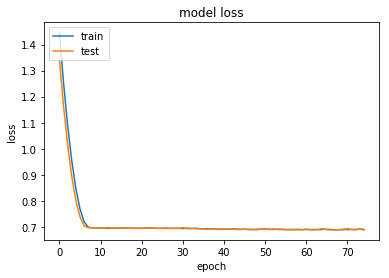

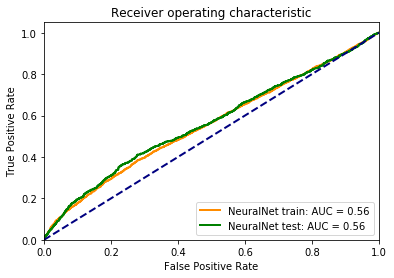

In [47]:
# Neural Net

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping
from keras import regularizers
import tensorflow as tf
from numpy.random import seed
seed(42)

X_dim = X['train'].columns.size

# create model
dnn_model = Sequential()
dnn_model.add(Dense(32, input_dim=X_dim, activation='relu',kernel_regularizer=regularizers.l1(0.003)))
dnn_model.add(Dense(16, activation='relu'))
dnn_model.add(Dense(8, activation='relu'))
dnn_model.add(Dense(4, activation='relu'))
dnn_model.add(Dense(2, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))


# Compile model
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

# Fit the model
history = dnn_model.fit(
    X['train'], y['train'], 
    epochs=75, 
    batch_size=256,
    shuffle=True,
    validation_data=(X['test'],y['test']),
    callbacks=[early_stop],
    verbose=0,
    )


print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

fpr_nn, tpr_nn, _, auc_nn = evaluate_model(dnn_model,X_scaled,['train','test'],'NeuralNet')

# Comparison of models

Summary of all the model evaluations.

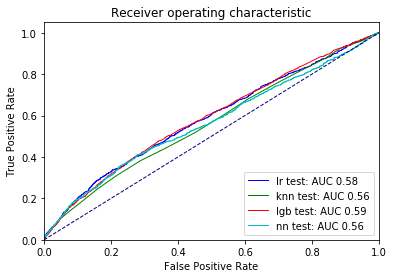

In [48]:
# TODO: Plot one graph with all models' test set ROC curve.

fprs = {}
fprs['lr']  = fpr_lr
fprs['knn'] = fpr_knn
fprs['lgb'] = fpr_lgb
fprs['nn']  = fpr_nn

tprs = {}
tprs['lr']  = tpr_lr
tprs['knn'] = tpr_knn
tprs['lgb'] = tpr_lgb
tprs['nn']  = tpr_nn

aucs = {}
aucs['lr']  = auc_lr
aucs['knn'] = auc_knn
aucs['lgb'] = auc_lgb
aucs['nn']  = auc_nn

kwargs = {}
kwargs['fprs'] = fprs
kwargs['tprs'] = tprs
kwargs['aucs'] = aucs

plot_ROC_compare_models(**kwargs)
